##Install Vectice


Here is a link to the Python SDK Documentation, it's not final nor complete and it is updated as we go along. 
[Python SDK Documentation](https://doc-dev.vectice.com/)

This notebook walks you through the process of dataset versioning by creating datsets, new dataset versions when modifying the original dataset and enabling you to add resources to a dataset version.

In [ ]:
!pip3 install -q vectice
!pip3 install -q fsspec
!pip3 install -q gcsfs

In [ ]:
!pip3 show vectice

Name: vectice
Version: 0.0.6
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: requests, GitPython, PyGithub, python-dotenv
Required-by: 


## Import the required packages


In [ ]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


## Retreive the data from GCS

In [ ]:
# Load your json key file to access GCS 
# The name should be something like test.json
from google.colab import files
uploaded = files.upload()

## Connect to your Vectice project

Here we are going to need an API token and a project token. An API token is used to secure requests between your existing tools and Vectice. You can create and manage those at the API TOKENS tab in your workspace, and they impersonate you and your rights per workspace, so we strongly recommend you to avoid sharing them.
A project token is used to target the project you're working on in the UI and can found (after creating a project) in the Project settings page, and anyone working on the project can see it and copy/paste it.

In [ ]:

os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"
##Complete with your Vectice API token
os.environ['VECTICE_API_TOKEN'] = "YOUR API TOKEN"

from vectice import Vectice

##Complete with your Vectice project token
vectice = Vectice(project_token="YOUR PROJECT TOKEN")

print(vectice)

## We create a dataset (from a bucket in GCS) in the UI from the SDK

We can either create a dataset using the connection name, or the connection id. For both methods, we should specify the connection id/name, the dataset name, the list of files and the list of folders that our dataset will contain. to create a dataset just with folders (that may contain files) we should put None in the files list argument when we call one of the two functions. For exemple:
- **vectice.create_dataset_with_connection_id(366, "dataset_versioning", None, folders)** and **vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning", None, folders)** enable to create a dataset named dataset_versioning using the connection whose id/name is 366/Connection_name and add the list of folders **folders** to the dataset.
- **vectice.create_dataset_with_connection_id(366, "dataset_versioning", files)** and **vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning",files)** enable to create a dataset named dataset_versioning using the connection whose id/name is 366/Connection_name and add the list of files **files** to the dataset
- **vectice.create_dataset_with_connection_id(366, "dataset_versioning", files, folders)** and **vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning", files, folders)** enable to create a dataset named dataset_versioning using the connection whose id/name is 366/Connection_name and add the list of files **files** and the list of folders **folders** to the dataset

In [ ]:
## Here we need the connectionId. You should first have a connection in the UI to be able to create a dataset. 
## You can find the connectionId in the URL (the value for integration eg: https://beta.vectice.com/organization/workspace/connections/edit?orgId=&w=&integration=366) 
##of the CONNECTIONS page of your workspace
files = ["gs://test_ui_bucket/img10"]
folders = ["gs://test_ui_bucket/Raw_data"]
vectice.create_dataset_with_connection_id(366, "dataset_versioning", None, folders)
## Or we can use the connection name to create a dataset from the folde Raw_data that contain our dataset
#vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning", None, folders)
#vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning", files)
#vectice.create_dataset_with_connection_name("Connection_name", "dataset_versioning", files, folders)

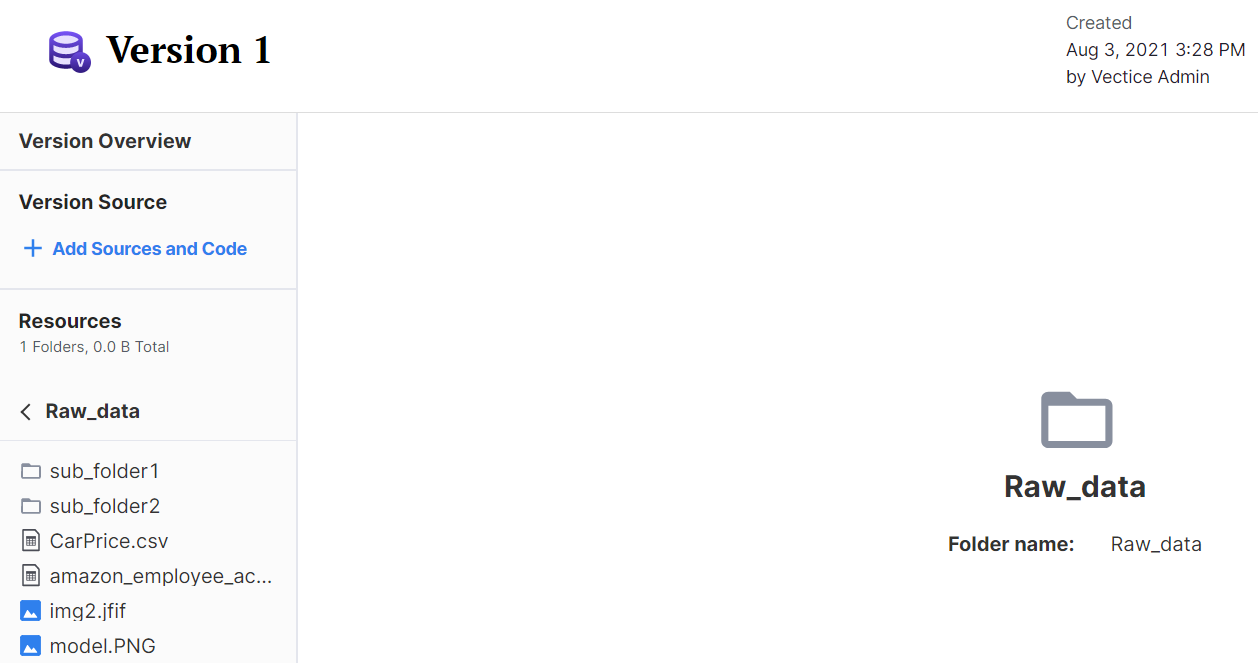

## Modify a file in the original dataset 

Let's make modifications in a file in the bucket and create another version of the dataset that takes into account those modifications

In [ ]:
## Complete with the name of your json key file access to GCS
##Don't forget the extension when you type the name of the json key file eg: test.json
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'The name of your json key file access to GCS (eg: test.json) '

train_df = pd.read_csv("gs://test_ui_bucket/Raw_data/CarPrice.csv")
# Run head to make sure the data was loaded properly
print(train_df.head())

   car_ID  symboling                   CarName  ... citympg highwaympg    price
0       1          3        alfa-romero giulia  ...      21         27  13495.0
1       2          3       alfa-romero stelvio  ...      21         27  16500.0
2       3          1  alfa-romero Quadrifoglio  ...      19         26  16500.0
3       4          2               audi 100 ls  ...      24         30  13950.0
4       5          2                audi 100ls  ...      18         22  17450.0

[5 rows x 26 columns]


In [ ]:
## We can take a looke at the features
train_df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [ ]:
## We drop the column "doornumber"
train_df = train_df.drop("doornumber", 1)

In [ ]:
train_df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')

We dropped the "doornumber" column.

Let's now upload the changes to the CarPrice file in GCS and create another dataset_version. It should take into account the modifications we made

In [ ]:
vectice.create_run("Test_dataset_version").with_tag("Dataset_version", "Dataset_version")
with vectice.start_run(inputs=[input_ds_version]) as run:
  ## We ulpoad the changes to the bucket in GCS
  train_df.to_csv("gs://test_ui_bucket/Raw_data/CarPrice.csv", index = False, header = True)
  ## We create a second version
  input_ds_version2 =  vectice.create_dataset_version().with_parent_name("dataset_versioning").with_tag("dataset_tag","dataset_tag").with_properties([("A property", "A value"),
                                                                                                                                                   ("A second property", "A value")])
  run.add_outputs([input_ds_version2])

2051

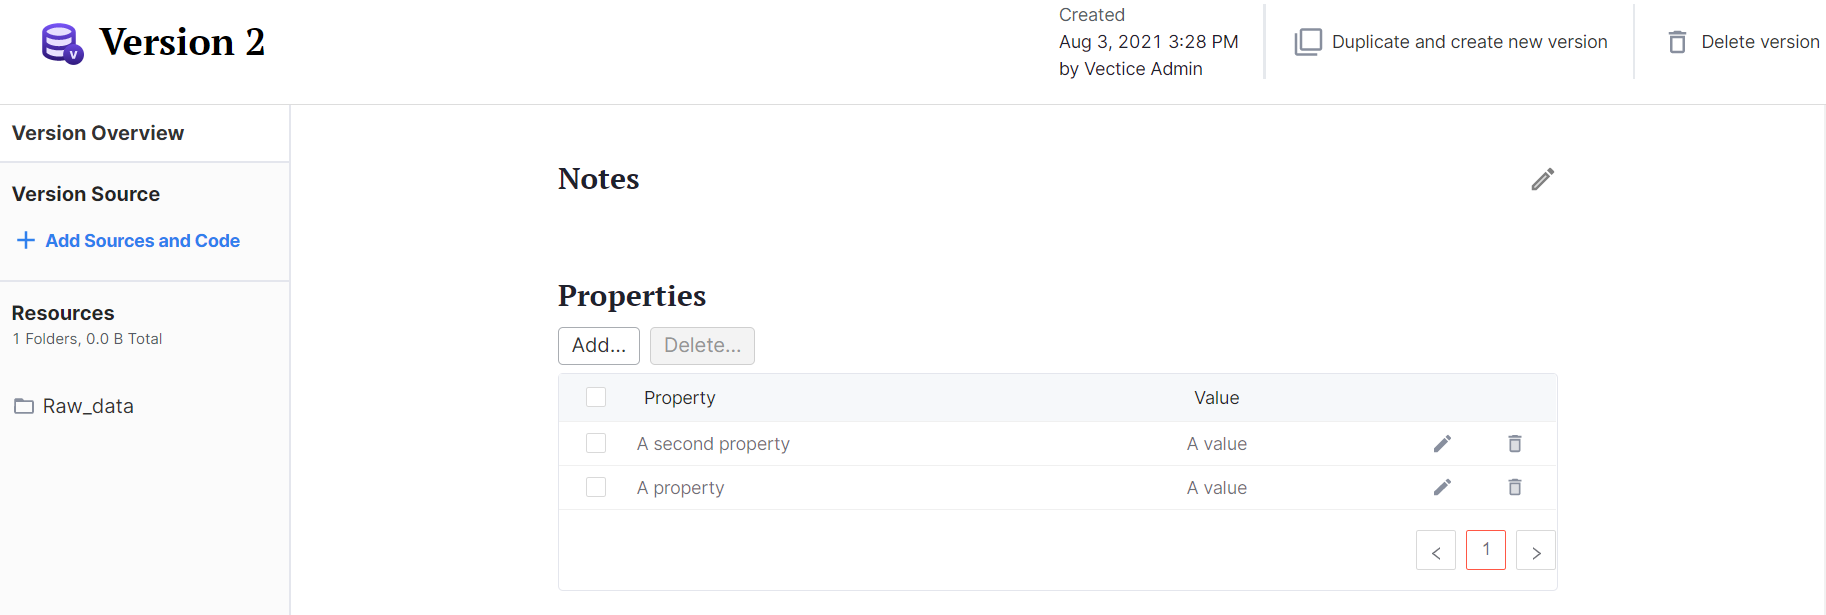

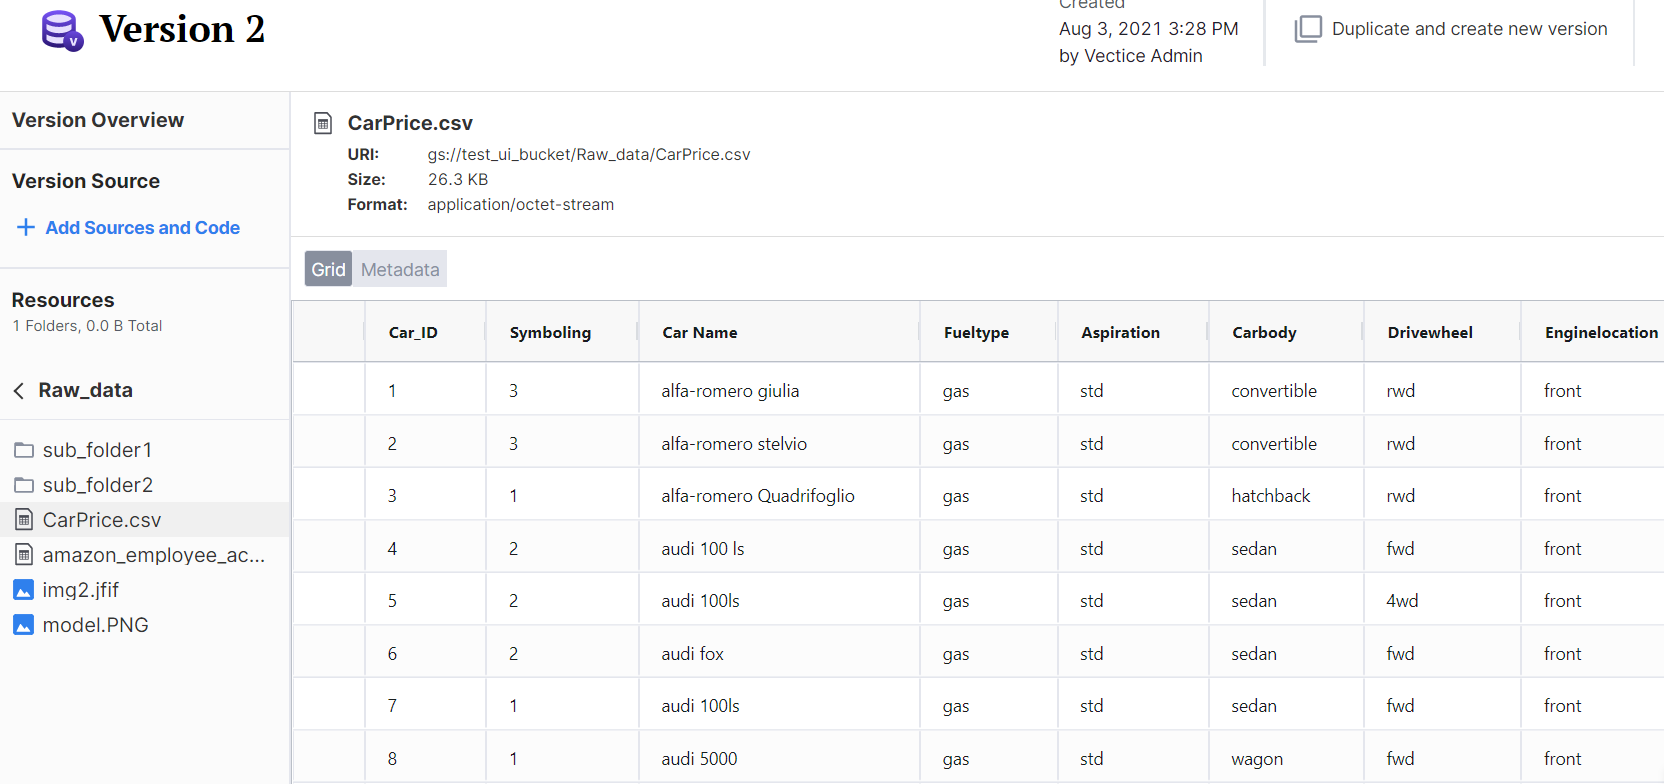

A new version is created since we modified the file CarPrice.

## Delete a folder/file from the original dataset

In [ ]:
## We list the folders and files contained in our bucket
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.get_bucket('test_ui_bucket')

blobs = bucket.list_blobs(prefix='Raw_data/')

for blob in blobs:
    print(blob.name)

Raw_data/
Raw_data/CarPrice.csv
Raw_data/amazon_employee_access_train.csv
Raw_data/img2.jfif
Raw_data/model.PNG
Raw_data/sub_folder1/
Raw_data/sub_folder1/3.PNG
Raw_data/sub_folder1/img10.jfif
Raw_data/sub_folder1/img8.jfif
Raw_data/sub_folder2/
Raw_data/sub_folder2/img1.jfif
Raw_data/sub_folder2/img2.jfif
Raw_data/sub_folder2/img3.jfif


In [ ]:
vectice.create_run("Test_dataset_version").with_tag("Dataset_versioning", "Dataset_versioning")
with vectice.start_run(inputs=[input_ds_version2]) as run:
  ## We delete the img2 from the bucket
  blob = bucket.list_blobs(prefix='Raw_data/img2.jfif')
  bucket.delete_blobs(blob)
  ##we create another version
  input_ds_version3 =  vectice.create_dataset_version().with_parent_name("dataset_versioning").with_tag("dataset_tag","dataset_tag").with_properties([("A property", "A value"),
                                                                                                                                                   ("A second property", "A value")])
  run.add_outputs([input_ds_version3])

2052

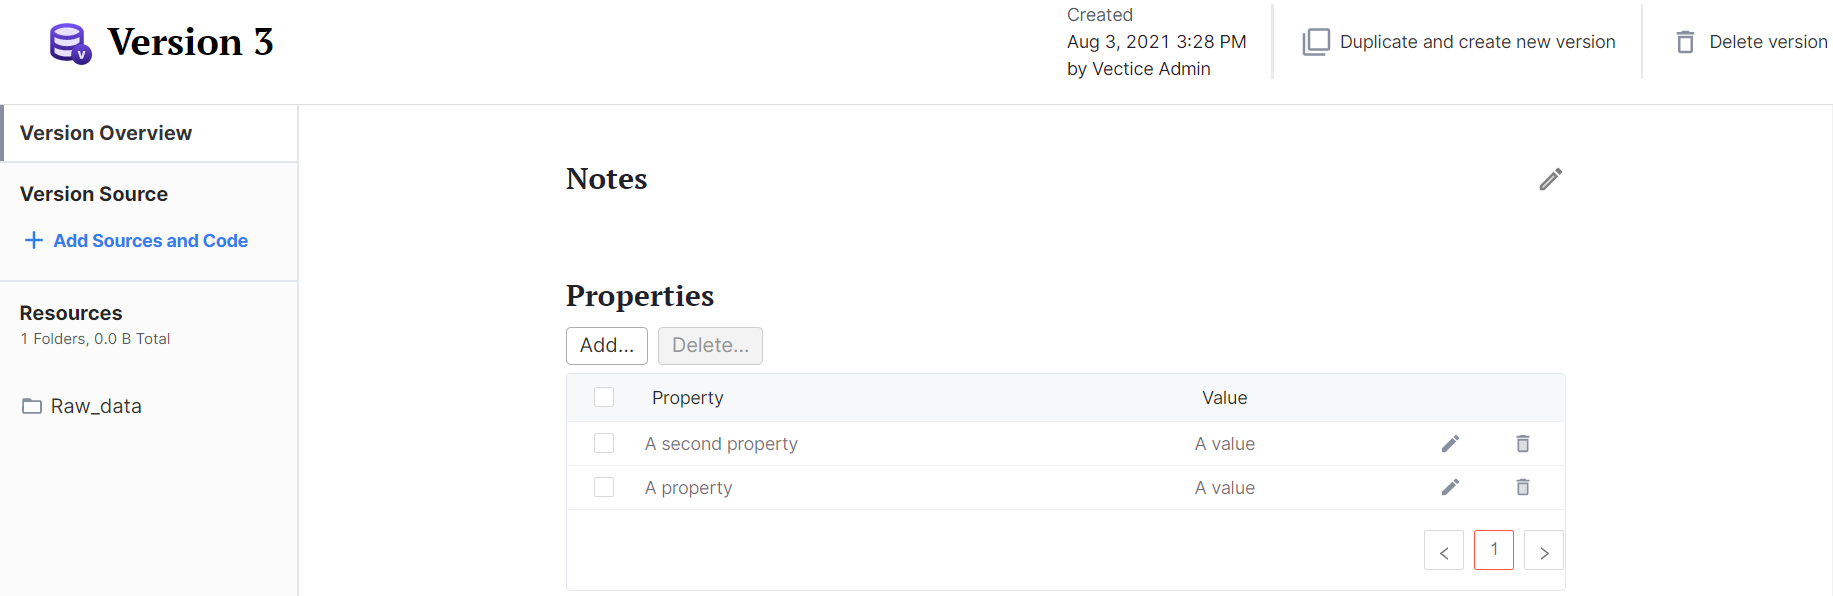

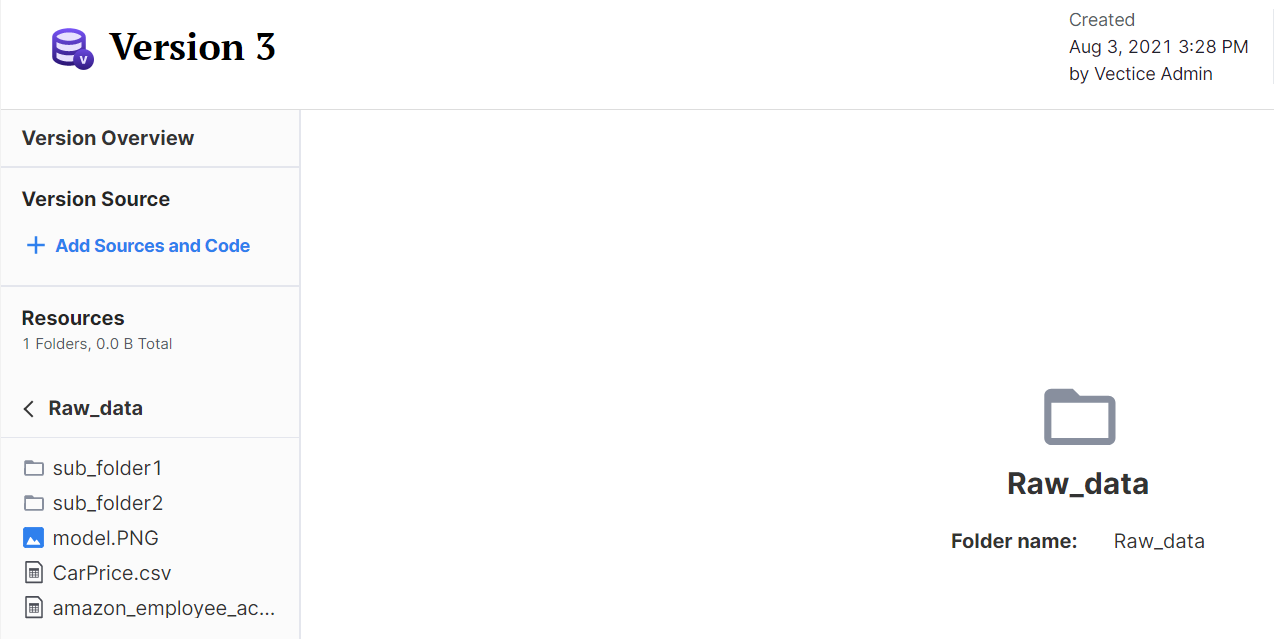

We can see in the image above that the modifications have been taken into account. But, what if we delete a folder from the storage account?

In [ ]:
vectice.create_run("Test_dataset_version").with_tag("Dataset_versioning", "Dataset_versioning")
with vectice.start_run(inputs=[input_ds_version3]) as run:
### We delete sub_folder2
  blob = bucket.list_blobs(prefix='Raw_data/sub_folder2/')
  bucket.delete_blobs(blob)
## ## We create another dataset_version
  input_ds_version4 =  vectice.create_dataset_version().with_parent_name("dataset_versioning")
  run.add_outputs([input_ds_version4])

2053

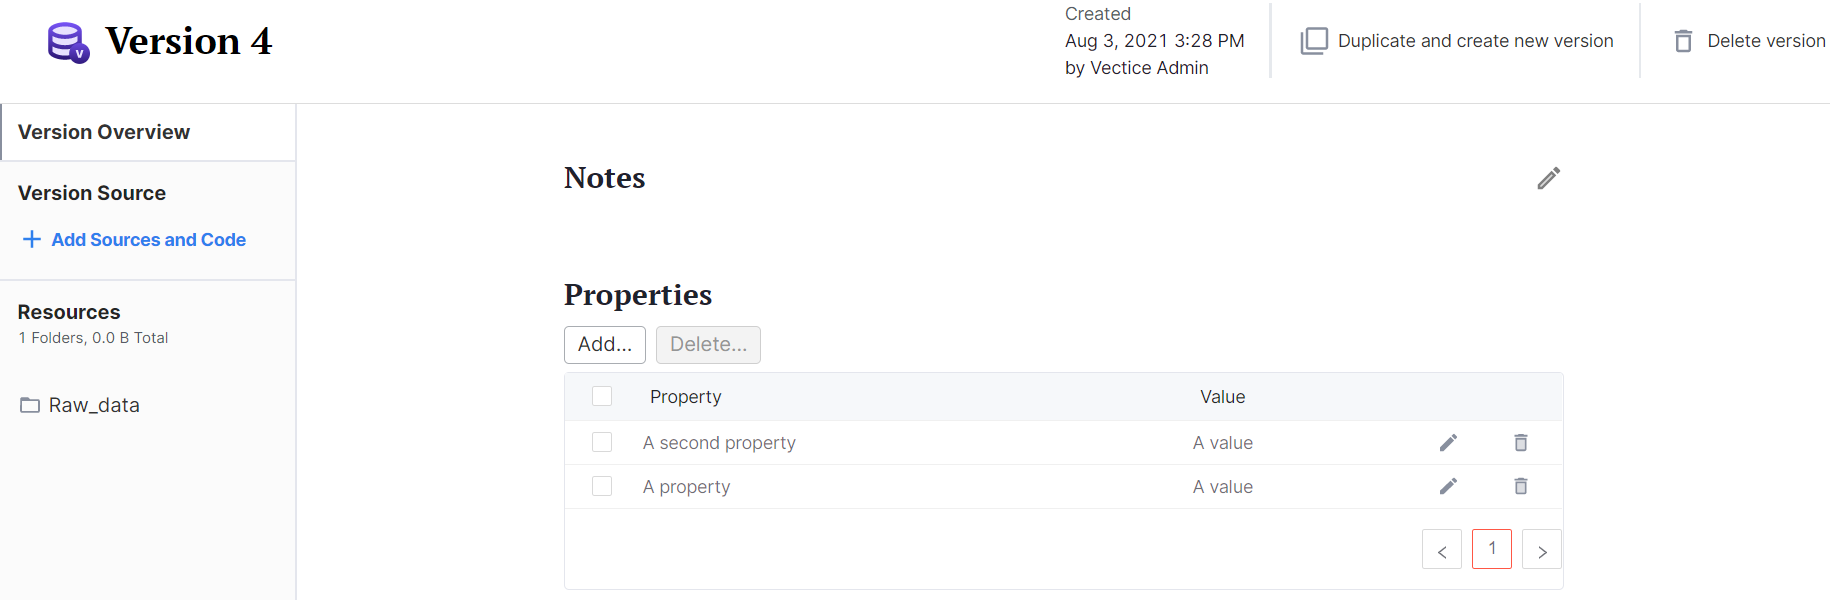

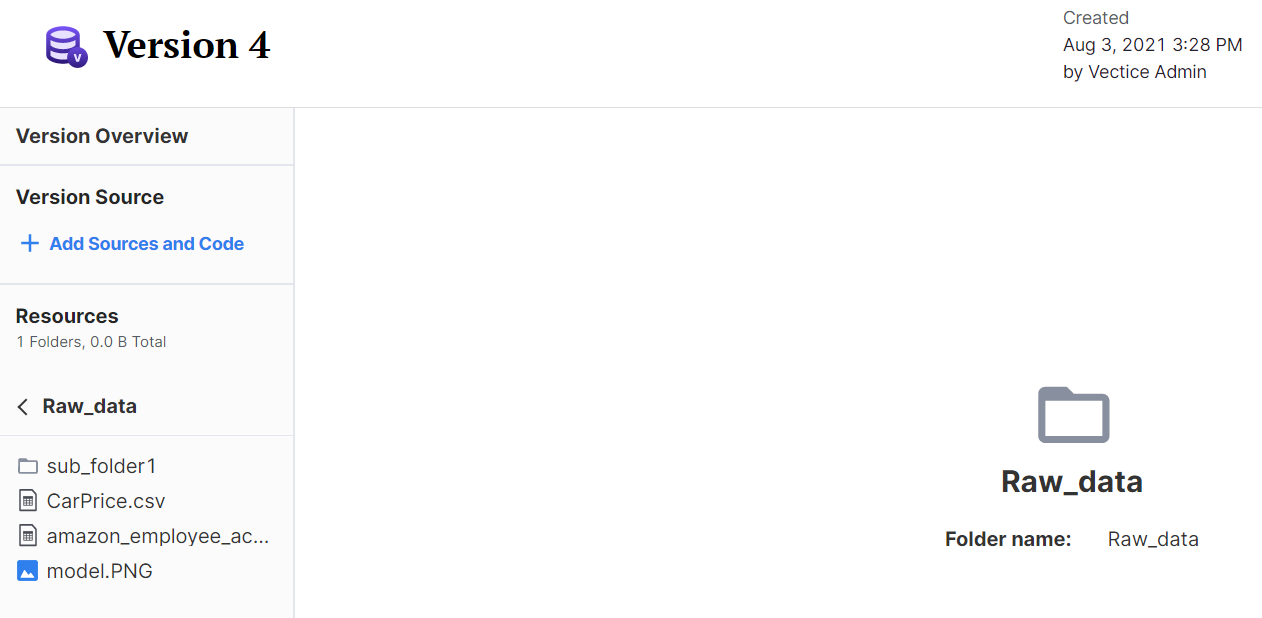

A new dataset version is created and it takes into account the modifications

## Adding files and folders to the bucket and creating new dataset versions

We create a dataset version and see if it takes into account the new added file and folder.

In [ ]:
vectice.create_run("Test_dataset_version").with_tag("Dataset_versioning", "Dataset_versioning")
with vectice.start_run(inputs=[input_ds_version4]) as run:
### We add img8.jfif to the bucket
  # Name of the object to be stored in the bucket
  object_name_in_gcs_bucket = bucket.blob('Raw_data/img8.jfif')
# Name of the object in local file system
  object_name_in_gcs_bucket.upload_from_filename('img8.jfif')
## We add the folder "new_folder" to the bucket  
  # Name of the object to be stored in the bucket
  object_name_in_gcs_bucket2 = bucket.blob('Raw_data/new_folder/img1.jfif')
# Name of the object in local file system
  object_name_in_gcs_bucket2.upload_from_filename('img1.jfif')

  input_ds_version5 =  vectice.create_dataset_version().with_parent_name("dataset_versioning")
  run.add_outputs([input_ds_version5])

2054

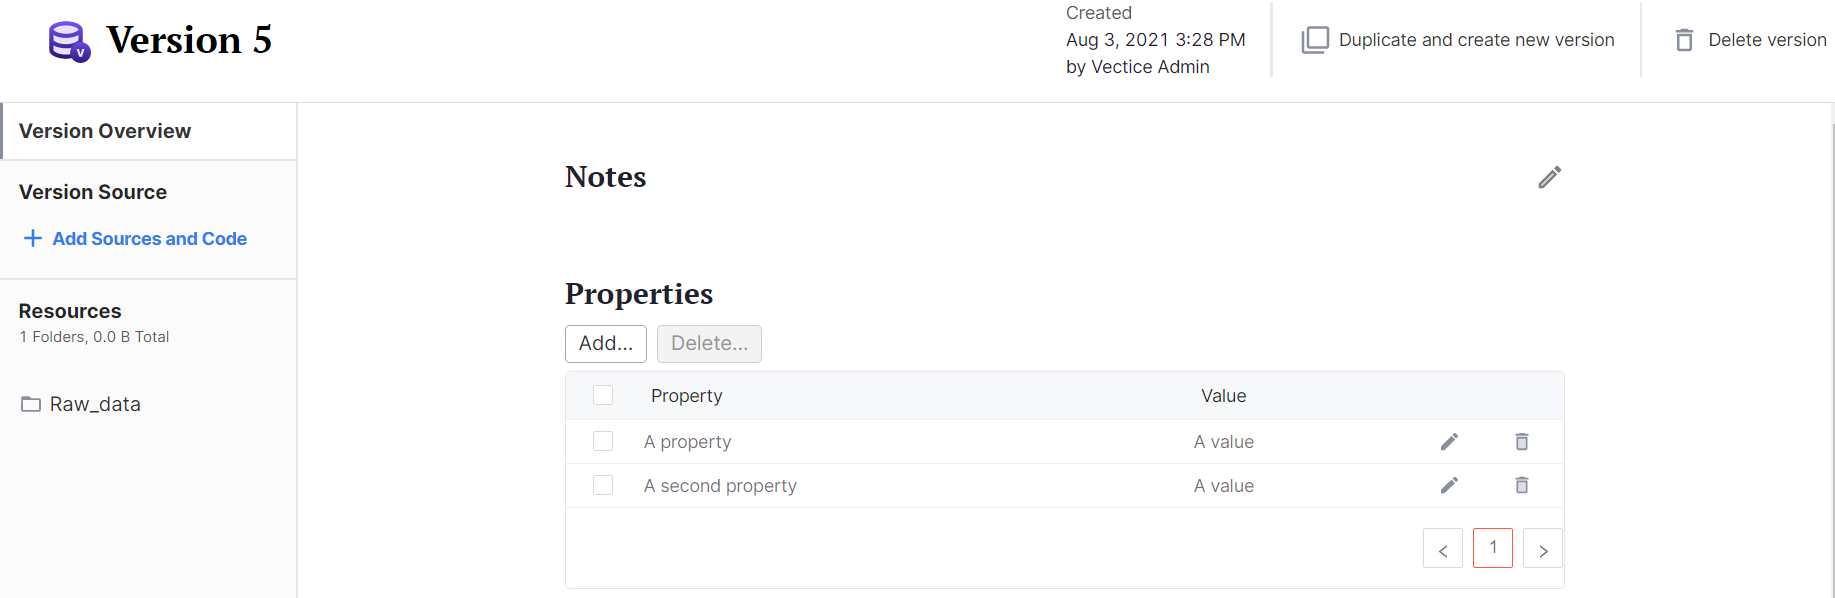

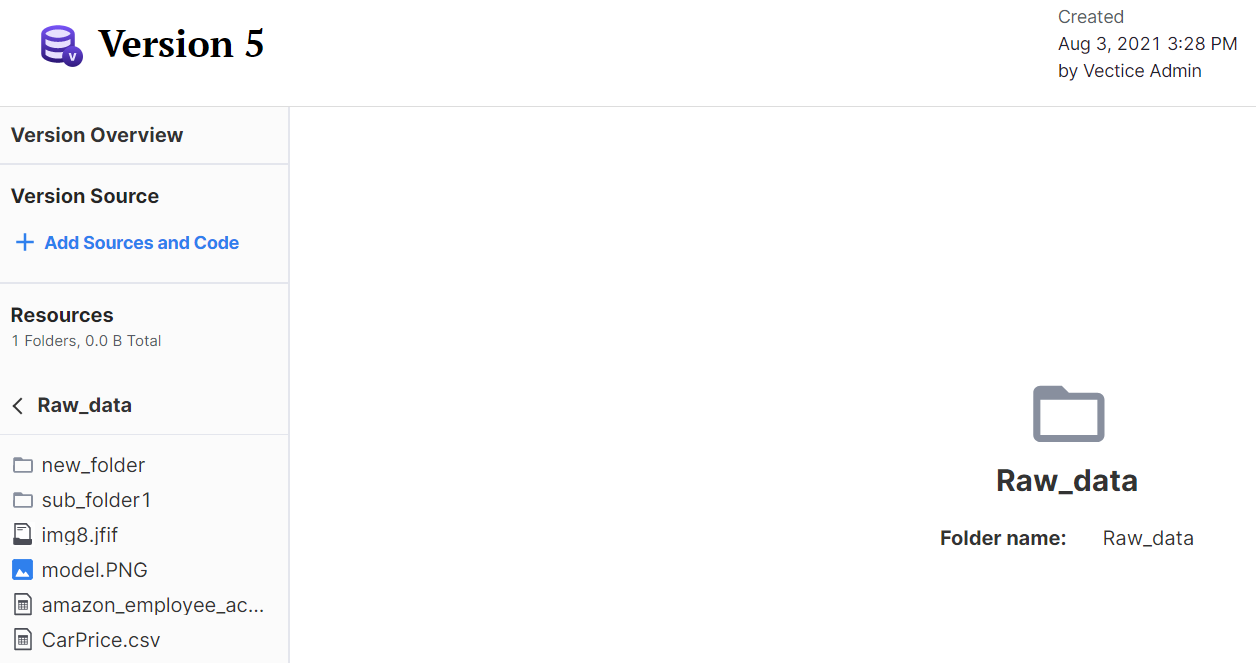

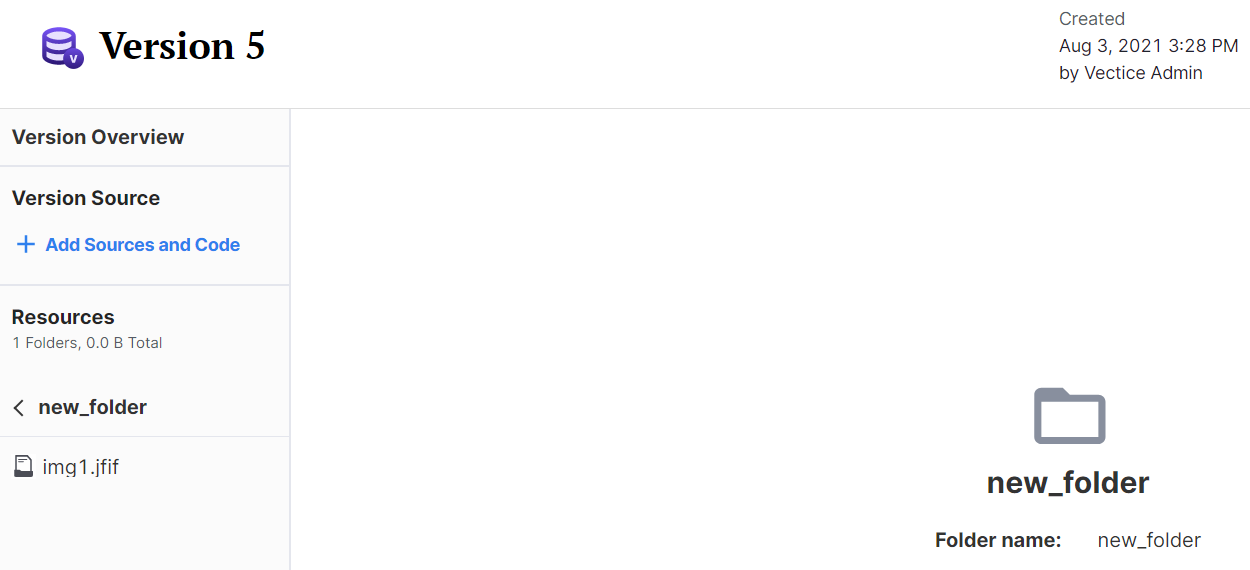

The modifications have been taken into account.

## Add resources to a dataset version

Vectice enable you to add resources to a new dataset version

In [ ]:
input_ds_version =  vectice.create_dataset_version().with_parent_name("dataset_versioning").with_auto_version().with_resources(["gs://test_ui_bucket/Raw_data/model.PNG"], ["gs://test_ui_bucket/Raw_data/new_folder"])

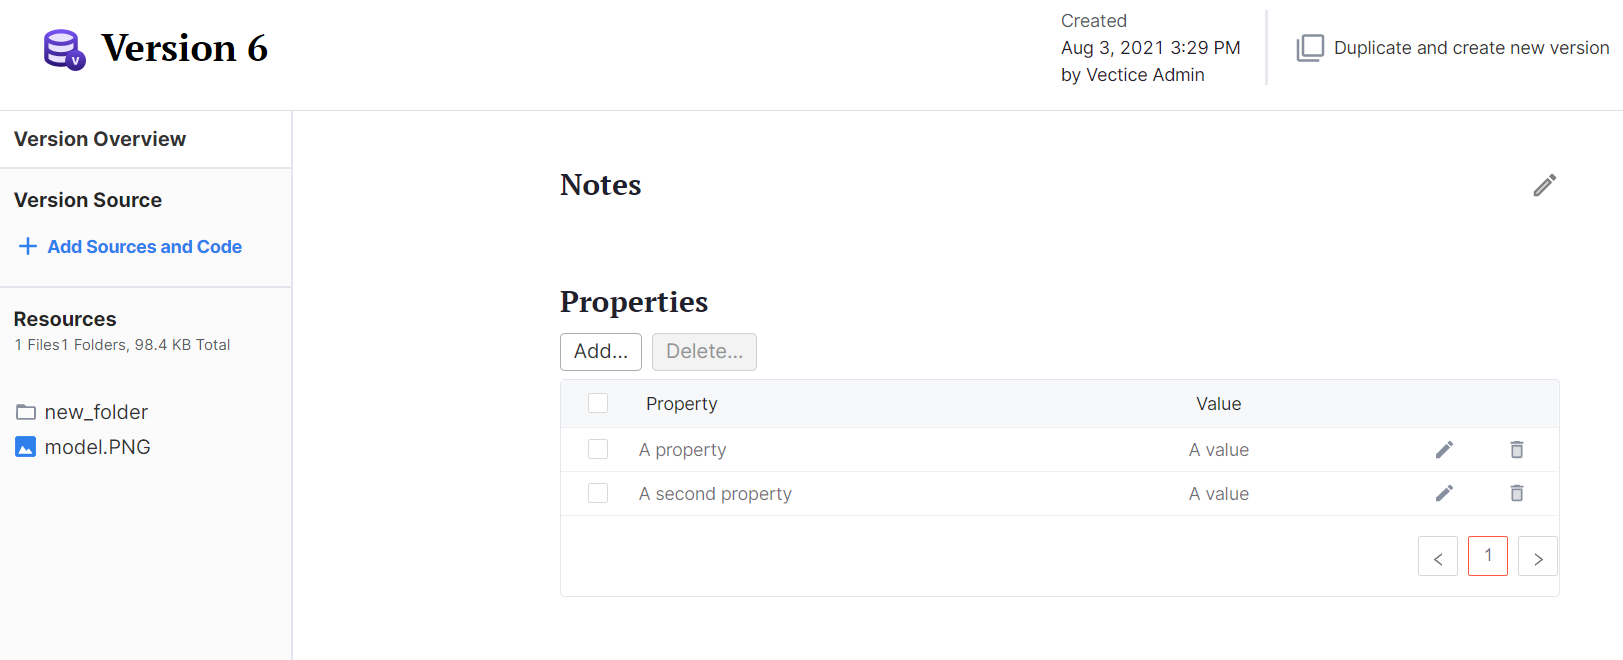

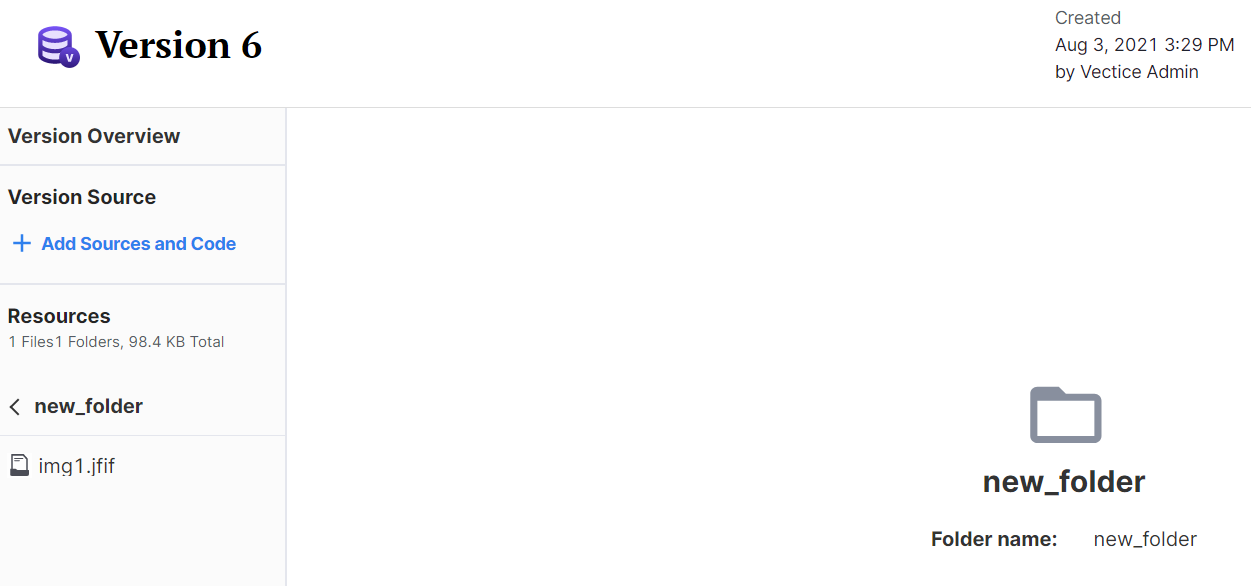

We can see in the images above that a new version is created with the new resources we specified